In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import MLGLUE
import time as time_module

import warnings
warnings.filterwarnings("ignore")

np.random.seed(1)

In [2]:
# load data
df = pd.read_csv("./hourly_data/02472000_hourly_nldas_LeafRiver.csv", parse_dates=[0], usecols=[0, 4, 8, 9], index_col=0)
df_flow = pd.read_csv("./hourly_data/02472000-usgs-hourly_LeafRiver.csv", parse_dates=[0], usecols=[0, 1, 6], index_col=0)

et_data = df.iloc[:, 0]
et_data = np.where(et_data < 0, 0., et_data)

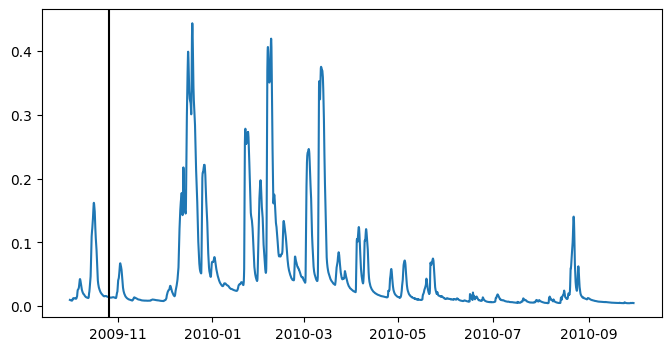

In [3]:
start_, end_ = "2009-10-01", "2010-09-30"


# make series and handle units
p_series = pd.Series(data=df.iloc[:, 2], index=pd.DatetimeIndex(df.index)).truncate(before=start_, after=end_).interpolate() # mm/d
et_series = pd.Series(data=et_data, index=pd.DatetimeIndex(df.index)).truncate(before=start_, after=end_).interpolate() # mm/d
qout_series = pd.Series(data=df_flow.iloc[:, 0], index=pd.DatetimeIndex(df.index)).truncate(before=start_, after=end_).interpolate() # mm/d

# set up everything for the model
steps = [1, 2, 4]

p_series_euler = p_series.copy().values
pet_series_euler = et_series.copy().values

# parameters
params = [1000, 1., 0.5, 0.05, 0.2]

warmup = 24 * 25

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(qout_series)
ax.axvline(qout_series.index[warmup], c="black")

In [4]:
def hymod_euler(Precip, PET, smax, beta, alpha, k_slow, k_quick, step=1):
    # initialize states
    s_upper_zone = 1.
    s_slow = 1.
    s_quick = [1., 1., 1.]
    
    # initialize global outflow data structure
    outflow = []
    # initialize state data structure
    states = []
    # get number of time steps
    tmax = len(Precip)
    
    # ensure that step is an integer
    step = int(step)
    # initialize time step
    t = 0
    
    while t < tmax:
        # compute precipitation excess from upper zone
        s_upper_zone, outflow_upper_zone = upper_reservoir_euler(
            state = s_upper_zone,
            inflow = Precip[t],
            pet = PET[t],
            beta = beta,
            smax = smax,
            step = step
        )
        
        # split outflow from upper zone
        inflow_slow = (1 - alpha) * outflow_upper_zone
        inflow_quick = alpha * outflow_upper_zone
        
        # compute slow reservoir contribution to global outflow
        s_slow, outflow_slow = linear_reservoir_euler(
            state = s_slow,
            inflow = inflow_slow,
            k = k_slow,
            step = step
        )
        
        # update global outflow
        global_outflow = outflow_slow
        
        # compute contribution of quick reservoir series to global outflow
        for n in range(3):
            s_quick[n], inflow_quick = linear_reservoir_euler(
                state = s_quick[n],
                inflow = inflow_quick,
                k = k_quick,
                step = step
            )
            
        # update global outflow
        global_outflow += inflow_quick
            
        # save global outflow
        outflow.append(global_outflow)
        
        # increment time step index
        t += step
    
    return outflow

def linear_reservoir_euler(state, inflow, k, step):
    """
    Computes state y_(n+1) from state y_(n) using the Euler method
    for a linear reservoir with inflow and storage coefficient k.
    
    Parameters
    ----------
    :param state: the current state y_(n); float
    :param inflow: the inflow flux [L/T] at time step (n); float
    :param k: storage coefficient [1/T]; float
    :param step: the step size of the Euler method; float
    
    Returns
    -------
    :return new_state: the new state y_(n+1); float
    :return outflow: the outflow from the reservoir; float
    """
    
    dSdt = inflow - k * state
    outflow = k * state
    new_state = state + step * dSdt
    
    if new_state < 0.:
        new_state = 0.
        
    if outflow < 0.:
        outflow = 0.
    
    return new_state, outflow

def upper_reservoir_euler(state, inflow, pet, beta, smax, step):
    """
    Computes state y_(n+1) from state y_(n) using the Euler method
    for the HYMOD upper reservoir with inflow, evaporation, maximum
    storage height, and distribution coefficient.
    
    see https://superflexpy.readthedocs.io/en/latest/popular_models.html#hymod
    for the governing equations
    
    Parameters
    ----------
    :param state: the current state y_(n); float
    :param inflow: the inflow flux [L/T] at time step (n); float
    :param pet: the potential evapotranspiration flux [L/T] at time
        step (n); float
    :param beta: the distribution coefficient; float
    :param smax: the maximum storage height [L]; float
    :param step: the step size of the Euler method; float
    
    Returns
    -------
    """
    
    s_bar = state / smax
    
    if state - pet > 0.:
        pet = pet
    else:
        pet = pet - state
    
    dSdt = inflow - pet - inflow * (1 - min(1, max(0, (1 - s_bar))) ** beta)
    
    outflow = inflow * (1 - min(1, max(0, (1 - s_bar))) ** beta)
    new_state = state + step * dSdt
    
    if new_state < 0.:
        new_state = 0.
        
    if outflow < 0.:
        outflow = 0.
    
    return new_state, outflow

In [5]:
def hymod_euler_model(parameters, level, n_levels, obs, likelihood, run_id):
    
    step = 1
    if n_levels == 3:
        if level == 0:
            step = 4
        elif level == 1:
            step = 2
        elif level == 2:
            step = 1
    elif n_levels == 1:
        step = 1
    else:
        print("please define the coarsening for your chosen number of levels")
        
    outflow = hymod_euler(
        Precip=p_series_euler,
        PET=pet_series_euler,
        smax=parameters[0],
        beta=parameters[1],
        alpha=parameters[2],
        k_slow=parameters[3],
        k_quick=parameters[4],
        step=step
    )
    
    # resample solution to original frequency via linear interpolation
    outflow = pd.Series(outflow, index=p_series.index[::step]).reindex(p_series.index).interpolate().values
    
    # return None if there are NaN values in sol
    if np.any(np.isnan(outflow)):
        return None, None
    else:
        # calculate likelihood
        warmup = 24 * 25
        likelihood_ = likelihood.likelihood(obs=obs[warmup:], sim=outflow[warmup:])

        return likelihood_, outflow

In [ ]:
# MLGLUE

# define likelihood
mylike = MLGLUE.InverseErrorVarianceLikelihood_bias(
    threshold=0.02, T=1., weights=None
)

start_time = time_module.time()

# parameters: [c_max, b_exp, alpha, k_slow, k_quick]
mlglue = MLGLUE.MLGLUE(likelihood=mylike, model=hymod_euler_model,
                       upper_bounds=[1000., 2., 1., .1, .5], lower_bounds=[1., 0.1, 0., 0., 0.],
                       obs=qout_series.values, n_samples=1_000, n_levels=3,
                       multiprocessing=False, n_processors=None, tuning=.9,
                       hierarchy_analysis=False, include_bias=True)

samples, liks, results = mlglue.perform_MLGLUE()

print("time: ", time_module.time() - start_time)

print("Shape of samples: ", np.shape(samples))
print("Shape of results: ", np.shape(results))
print("Shape of likelihoods: ", np.shape(liks))

# uncertainty_estimates = mlglue.estimate_uncertainty(quantiles=[0.01, 0.5, 0.99])
# print(uncertainty_estimates)

# pd.DataFrame(uncertainty_estimates).to_csv("EX01_HYMOD_MLGLUE_uncertainty_estimates.csv")
# pd.DataFrame(samples).to_csv("EX01_HYMOD_MLGLUE_parameter_samples.csv")

# print(len(mlglue.highest_level_calls))


No samples provided, using uniform sampling...


2024-11-14 12:06:55,643	INFO worker.py:1819 -- Started a local Ray instance.



Starting tuning with multiprocessing...


Results of variance analysis: 
Correlation between subsequent levels (from lowest to highest level):
   0.91428   (level 0, level 1)
   0.99644   (level 1, level 2)
Note: those values should INCREASE with increasing level indices!


Variances of likelihoods on all levels (from lowest to highest level):
   7654.48897   (level 0)
   9506.56245   (level 1)
   10958.16268   (level 2)
Note: those values should be approximately constant across all levels!


The var. inequality holds between levels  0 and 1: 9506.56245 >= 1.56270e+03
The var. inequality holds between levels  1 and 2: 10958.16268 >= 1.24302e+02

The variance inequality holds between all two subsequent levels!
The cross-level variance decays monotonically!


Results of mean value analysis: 
Mean values of the difference between likelihoods on subsequent levels (from lowest to highest level):
   36.62100   (level 0, level 1)
   3.14059   (level 1, level 2)
Note: those values should DECR

2024-11-14 12:07:39,387	INFO worker.py:1819 -- Started a local Ray instance.



Starting sampling with multiprocessing...


KeyboardInterrupt: 

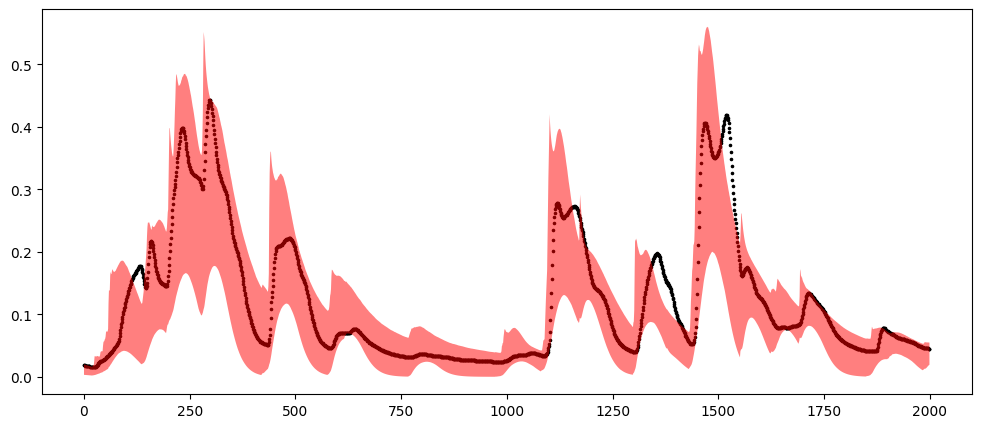

In [8]:
fig, ax = plt.subplots(figsize=(12, 5))

time_start, duration = 1000, 2000 # 19 / 20 
time_start, time_end = warmup + time_start, warmup + time_start + duration

ax.scatter([i for i in range(len(qout_series.values[time_start:time_end]))], qout_series.values[time_start:time_end], marker=".", c="black", s=10)
ax.fill_between([i for i in range(len(qout_series.values[time_start:time_end]))], uncertainty_estimates[time_start:time_end, 0], uncertainty_estimates[time_start:time_end, 2], facecolor="red", alpha=0.5)

In [9]:
# calculate rmse
rmse = np.sqrt((1 / len(qout_series)) * np.sum(np.abs(qout_series - uncertainty_estimates[:, 1]) ** 2))

# calculate R^2 
rsq = np.corrcoef(qout_series, uncertainty_estimates[:, 1])[0, 1]
rsq = rsq ** 2

# nse
nse = 1 - ((np.sum(np.abs(qout_series.values - uncertainty_estimates[:, 1]) ** 2)) / (np.sum(np.abs(qout_series.values - np.mean(qout_series.values)) ** 2)))

print(rmse)
print(rsq)
print(nse)

0.036273537920969434
0.8632623417923904
0.7779770202926629


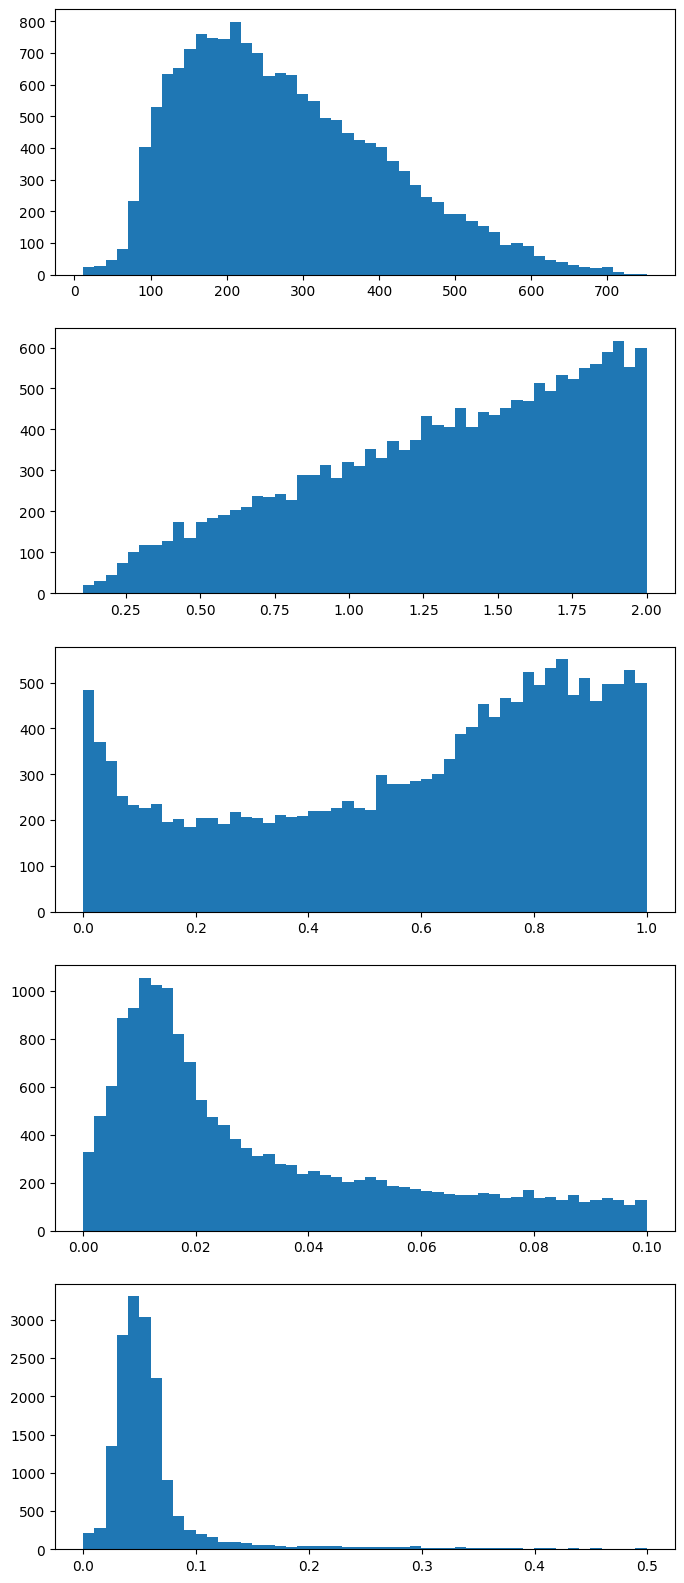

In [10]:
fig, ax = plt.subplots(nrows=5, figsize=(8, 20))

for i in range(5):
    ax[i].hist(np.array(samples)[:, i], 50)